### Analyze Taylor Swift Lyrics with Python

In [32]:
%matplotlib inline

import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

#### 1. Load the dataset

After running the first cell to load all necessary libraries, we need to load our dataset.

* Using pandas, load the dataset taylor_swift_lyrics and save it as lyrics.

* Use .info() to determine how many rows there are, check for missing values, and check the variable types.

In [ ]:
# Load dataset
lyrics = pd.read_csv('Projects/taylor_swift/dataset/taylor_swift_lyrics_2006-2022_all.csv')

# inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5


In [34]:
# get info about the dataframe
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9370 entries, 0 to 9369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9370 non-null   object
 1   track_title  9370 non-null   object
 2   track_n      9370 non-null   int64 
 3   lyric        9370 non-null   object
 4   line         9370 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 366.1+ KB


#### 2. Add essential data

We know that we want to explore her use of terms over years, but this dataset doesn't have years. We can either merge a dataset or manually create a new column. So, create a function that fills in the year based on the album name.

* Apply this function to the lyrics DataFrame to create a new column.

* Inspect the first few rows of the DataFrame

In [35]:
# get a list of all the albums in this collection
print(lyrics.album_name.unique())

['Fearless (Taylor’s Version)' 'Red (Deluxe Edition)' '1989 (Deluxe)'
 'midnights' 'midnights (3am edition)' 'reputation' 'Taylor Swift'
 'folklore (deluxe version)' 'Lover' 'evermore (deluxe version)'
 'Speak Now (Deluxe)']


In [36]:
# this is a function to map the name of the album to the year it was released
def album_release(row):  
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    #ok, we know folklore was actually released in Dec 2020, but this will make our analysis easier
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    #this is slightly differently formatted because the album name is recorded two ways.
    elif 'midnights' in row['album_name']:
        return '2022'
    
    return 'No Date'
     

# apply the function to the album
lyrics['album_year'] = lyrics.apply(lambda row: album_release(row), axis=1)

# inspect the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008


#### 3. Clean the lyric text

To accurately count keyword mentions, we need to: lowercase everything, remove punctuation, and exclude stop words.

Save this in a new column called clean_lyric.

In [37]:
# lower case
lyrics['clean_lyric'] = lyrics['lyric'].str.lower()

# remove punctuation
lyrics['clean_lyric'] = lyrics['clean_lyric'].str.replace(r'[^\w\s]', '', regex=True)

# remove stopwords
# create a small list of English stop words,feel free to edit this list
stop = ['the','a','this','that','to','is','am','was','were','be','being','been']

# there are three steps in one here - explained below
# we make a list of words with '.split()'
# then we remove all the words in our list
# then we join the words back together into a string
lyrics['clean_lyric']=lyrics['clean_lyric'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))

lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah


#### 4. Find keyword mentions

Because we are more interested in 'midnight', we will first count how many times midnight occurs in Taylor Swift's lyrics.

* Create a new column to indicate if the a lyric has 'midnight' in it.

* Check how many times midnight occurs

In [38]:
# create a new column to reflect if the lyrics contain midnight

lyrics['midnight'] = lyrics['clean_lyric'].str.contains('midnight')
sum(lyrics['midnight'])

20

#### 5. Expand the keyword list

Midnight might not be the only way that Taylor Swift has talked about night. We need to expand our list. We've made a list of night words and day words. 

* Create three new columns, one for night words, one for day words and one for time-related words.

* Join the lists into a regular expression string using the .join() function and the | to indicate "or"

* Check the clean lyrics for the presence of words in the regular expression you just made.

* Count how many times the words appeared and print them to the screen

* Inspect the first few rows of the lyrics DataFrame to be sure it looks as you expect

In [39]:
#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

#create a regular expression string for each list of words
night_regex = '|'.join(night)
day_regex = '|'.join(day)
time_regex = '|'.join(time)

#create a new column for each category of words
lyrics['night'] = lyrics['clean_lyric'].str.contains(night_regex)
lyrics['day'] = lyrics['clean_lyric'].str.contains(day_regex)
lyrics['time'] = lyrics['clean_lyric'].str.contains(time_regex)

#count the number of times each category of word appears in the lyrics
night_count = sum(lyrics['night'])
day_count = sum(lyrics['day'])
time_count = sum(lyrics['time'])

#print the count of each word category
print("night words: ", night_count)
print("day words: ", day_count)
print("time words: ", time_count)

#inspect the first few rows
lyrics.head()

night words:  287
day words:  387
time words:  35


,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False


#### 6. Visualize how Taylor Swift's mentions of time have changed over time.

Now that we know that she has referenced time, we can see if that has changed, and if she has been dropping any hints about her upcoming album.

* Create a new dataframe called yearly_mentions that groups her mentions by year, and takes the sum of the other columns. Reset the index on this DataFrame to make it easier to use with matplotlib

* Create a line chart in matplotlib showing the night mentions over time.

In [40]:
#create a new dataframe for yearly mentions that groups mentions by year
yearly_mentions = (
    lyrics.groupby('album_year')[lyrics.select_dtypes(include=['number','bool']).columns]
    .sum()
    .reset_index()
)
# yearly_mentions = lyrics.groupby('album_year').sum().reset_index()
yearly_mentions

,album_year,track_n,line,midnight,night,day,time
0,2006,4867,13456,0,19,25,3
1,2008,15644,27793,0,42,65,20
2,2010,8450,27489,0,31,53,4
3,2012,11992,27800,1,48,53,7
4,2014,8424,33546,2,27,41,0
5,2017,7640,33775,3,25,25,0
6,2019,8813,25741,0,22,46,0
7,2020,8443,25712,2,18,38,0
8,2021,6193,16854,1,8,17,1
9,2022,10553,27345,11,47,24,0


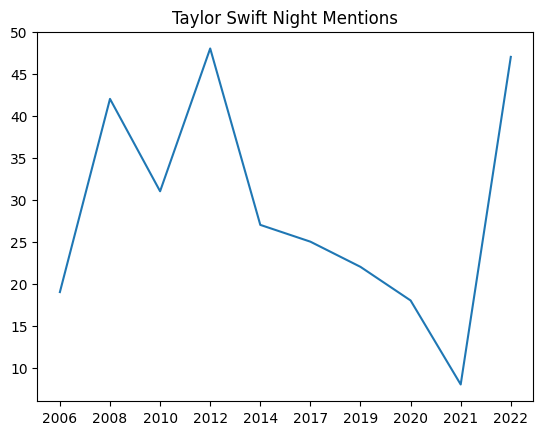

In [41]:
#plot the mentions of night over years
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'])
plt.title("Taylor Swift Night Mentions")
plt.show()

It looks like there was a peak in her mentioning night around 2012. It seems like those mentions have become less prevalent over time, with an actual dip in 2019! We had expected midnight to appear more often around then, based on rumors that she plans everything 3 years out.

#### 7. What albums are the most night/day focused?

Now that we have a table of counts, it's very easy to figure out which albums have the most mentions of day or night. But our DataFrame only has the years, not the album names. We need to add those back in.

* Reinstate the album name for this dataframe.

* Use .sort_values() to order the yearly_mentions table and find which year has the most mentions of night.

* Do the same for the day column.

In [ ]:
#reinstate the album name

#read the album_year_name.csv
year_name = pd.read_csv("Projects/taylor_swift/dataset/album_year_name.csv")

#sort both dataframes by year
yearly_mentions.sort_values(by='album_year', ascending=True, inplace=True)
year_name.sort_values(by='album_year', ascending=True, inplace=True)

#add the new column for album name
yearly_mentions['album_name'] = year_name['album_name']

In [43]:
#sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values(by='night', ascending=False)

,album_year,track_n,line,midnight,night,day,time,album_name
3,2012,11992,27800,1,48,53,7,reputation
9,2022,10553,27345,11,47,24,0,Midnights
1,2008,15644,27793,0,42,65,20,Red (Deluxe Edition)
2,2010,8450,27489,0,31,53,4,1989 (Deluxe)
4,2014,8424,33546,2,27,41,0,Taylor Swift
5,2017,7640,33775,3,25,25,0,folklore (deluxe version)
6,2019,8813,25741,0,22,46,0,Lover
0,2006,4867,13456,0,19,25,3,Fearless (Taylor’s Version)
7,2020,8443,25712,2,18,38,0,evermore (deluxe version)
8,2021,6193,16854,1,8,17,1,Speak Now (Deluxe)


Her most "nightly" album was reputation in 2012, whereas her least nightly album was also the one right before Midnight. Has she been saving all her night-related lyrics for the past 3 years?

In [44]:
#sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values(by='day', ascending=False)

,album_year,track_n,line,midnight,night,day,time,album_name
1,2008,15644,27793,0,42,65,20,Red (Deluxe Edition)
2,2010,8450,27489,0,31,53,4,1989 (Deluxe)
3,2012,11992,27800,1,48,53,7,reputation
6,2019,8813,25741,0,22,46,0,Lover
4,2014,8424,33546,2,27,41,0,Taylor Swift
7,2020,8443,25712,2,18,38,0,evermore (deluxe version)
0,2006,4867,13456,0,19,25,3,Fearless (Taylor’s Version)
5,2017,7640,33775,3,25,25,0,folklore (deluxe version)
9,2022,10553,27345,11,47,24,0,Midnights
8,2021,6193,16854,1,8,17,1,Speak Now (Deluxe)


It seems like her older work focused on day much more than her more recent. There was a period of time (2008-2012) when she was really focused on day, but it seems to have become less central to her work more recently.

#### 8. Compare day to night mentions

Create another line chart with both the night mentions and the day mentions

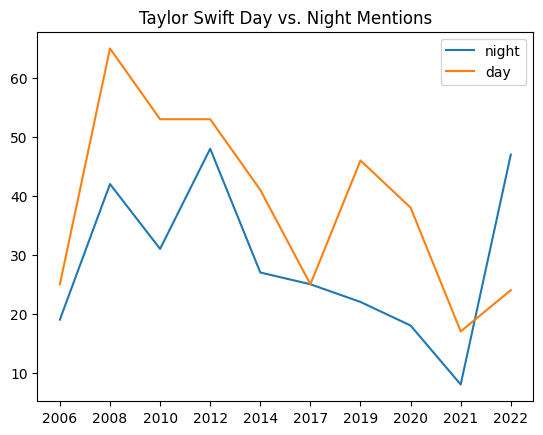

In [45]:
#create a plot with one line showing number of night references by year 
#and another line with the number of day references by year
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'], label = 'night')
plt.plot(yearly_mentions['album_year'], yearly_mentions['day'], label = 'day')
plt.title("Taylor Swift Day vs. Night Mentions")
plt.legend()
plt.show()

Well this is interesting. We see a similar dip in referencing time around 2017, but a sharp increase in both 2019 and 2020 to reference day.

#### 9. Investigate position of day vs. night mentions within albums


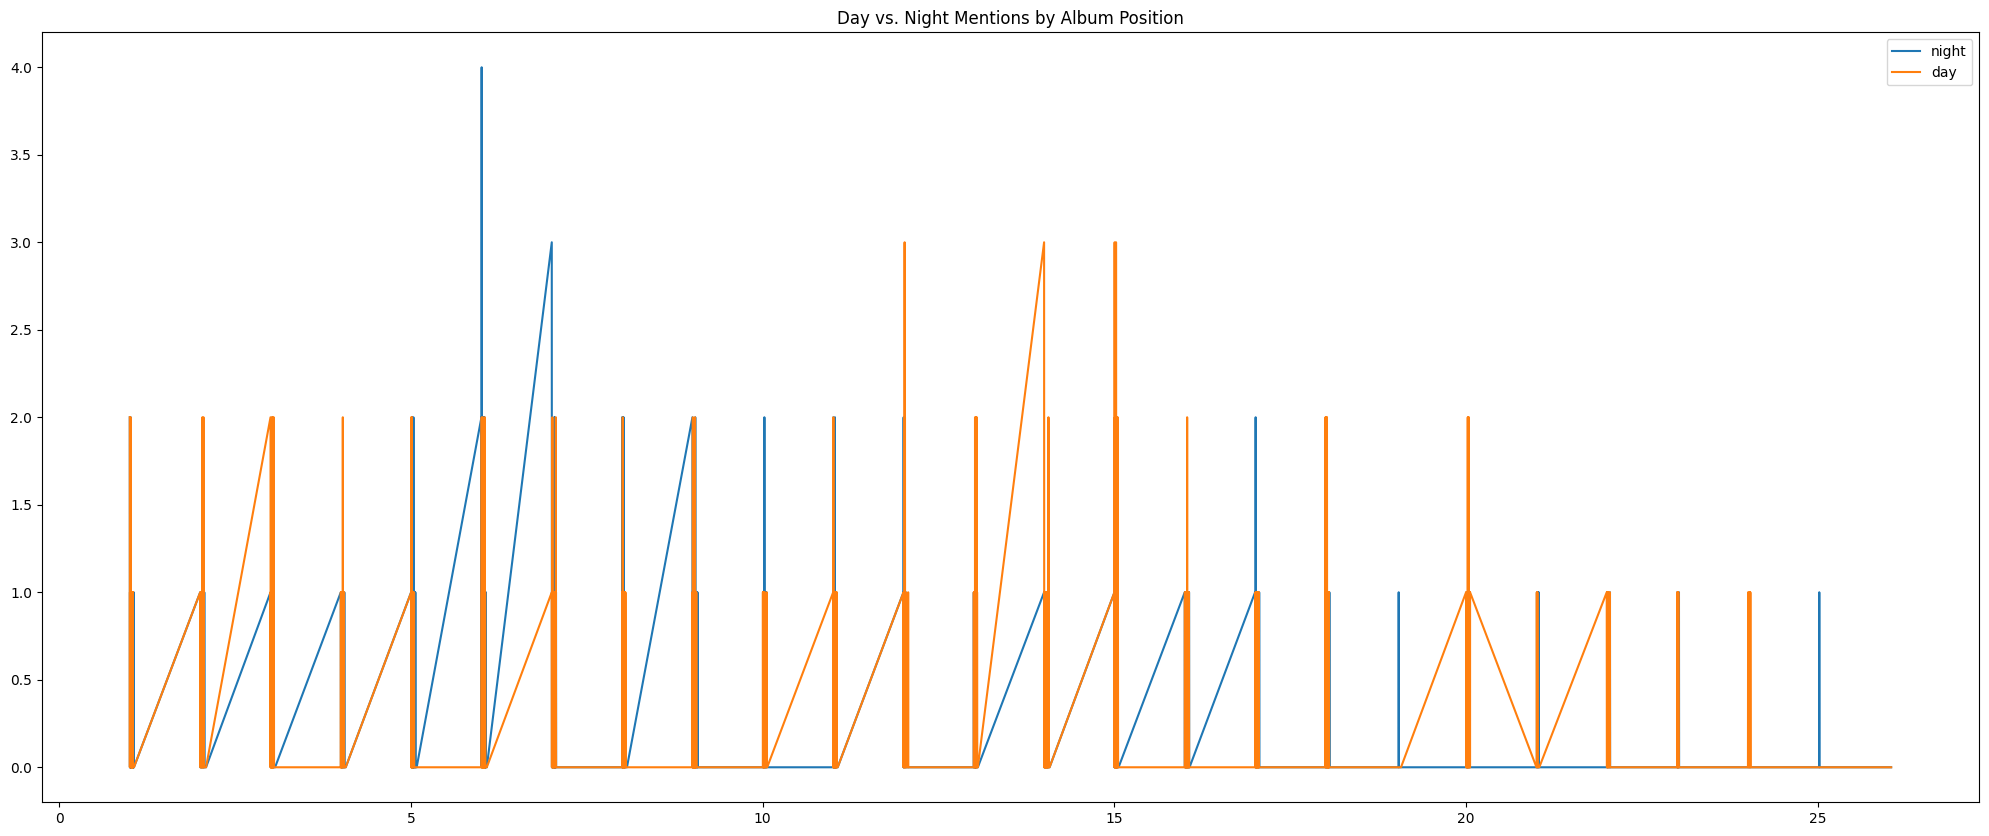

In [46]:
#create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + (lyrics['line']/1000)

#create a new DataFrame that is grouped by position
positional_mentions = lyrics.groupby('position').sum().reset_index()

#increase the size of the plot 
fig = plt.gcf()
fig.set_size_inches(25,10)

#create a plot with two lines to show frequency of day vs. night references by position in the album
plt.plot(positional_mentions['position'], positional_mentions['night'], label = 'night')
plt.plot(positional_mentions['position'], positional_mentions['day'], label = 'day')
plt.legend()
plt.title("Day vs. Night Mentions by Album Position")

plt.show()

Honestly not that much -- we can't see any strong trends here. Best to move on. 

#### 10. Tokenize the Lyrics

In [47]:
#tokenize the words in the clean_lyric column
lyrics['lyrics_tok'] = lyrics['clean_lyric'].str.split(' ')

In [48]:
#inspect the first few lines
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]"
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]"
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]"
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]"


In [49]:
#determine what words overall are the most frequently used words
#create a list of all the words in the lyrics_tok column
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

#use the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)
#sort the word frequencies to find out the most common words she's used. 
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
#call the word frequency
word_frequency

[('you', 3061),
 ('i', 2911),
 ('and', 1844),
 ('me', 1153),
 ('it', 1030),
 ('in', 1003),
 ('my', 927),
 ('your', 689),
 ('of', 667),
 ('all', 590),
 ('but', 581),
 ('im', 568),
 ('like', 552),
 ('on', 539),
 ('we', 538),
 ('know', 477),
 ('so', 454),
 ('oh', 447),
 ('its', 444),
 ('dont', 433),
 ('when', 417),
 ('never', 384),
 ('just', 374),
 ('youre', 367),
 ('for', 348),
 ('with', 332),
 ('love', 324),
 ('now', 321),
 ('what', 320),
 ('up', 305),
 ('out', 287),
 ('time', 286),
 ('cause', 283),
 ('if', 276),
 ('at', 276),
 ('back', 276),
 ('no', 239),
 ('are', 230),
 ('one', 222),
 ('do', 220),
 ('down', 218),
 ('got', 214),
 ('say', 212),
 ('see', 211),
 ('think', 202),
 ('they', 197),
 ('baby', 191),
 ('want', 189),
 ('can', 188),
 ('go', 188),
 ('not', 177),
 ('come', 175),
 ('could', 174),
 ('wanna', 170),
 ('have', 169),
 ('there', 168),
 ('right', 166),
 ('yeah', 166),
 ('ill', 165),
 ('he', 165),
 ('cant', 164),
 ('said', 158),
 ('ever', 150),
 ('get', 145),
 ('would', 144),

She mostly talks about you and then herself, while that's not surprising, it also tells us that she's mostly writing about relationships and her realtionships with others.

#### 11. Analyze Lyric Sentiment


In [50]:
#run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [51]:
#run this cell to see how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [52]:
#create a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,polarity
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."


In [53]:
#transforming the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]",0.000,1.000,0.000,0.0000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]",0.000,1.000,0.000,0.0000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]",0.000,1.000,0.000,0.0000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...",0.000,1.000,0.000,0.0000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]",0.000,0.694,0.306,0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9365,Speak Now (Deluxe),Superman,17,I'll be right here on the ground,51,2010,ill right here on ground,False,False,False,False,17.051,"[ill, right, here, on, ground]",0.412,0.588,0.000,-0.4215
9366,Speak Now (Deluxe),Superman,17,When you come back down,52,2010,when you come back down,False,False,False,False,17.052,"[when, you, come, back, down]",0.000,1.000,0.000,0.0000
9367,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",53,2010,la la la la la la,False,False,False,False,17.053,"[la, la, la, la, la, la]",0.000,1.000,0.000,0.0000
9368,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",54,2010,la la la la la la,False,False,False,False,17.054,"[la, la, la, la, la, la]",0.000,1.000,0.000,0.0000


#### 12. Corpus Sentiment Analysis


In [54]:
#calculate overall sentiment for pos, neg, sentiment
pos = sum(lyrics['pos'])
neg = sum(lyrics['neg'])
compound = sum(lyrics['compound'])

#print the overall sentiments
print("positive: ", pos)
print("negative: ", neg)
print("compound: ", compound)

positive:  1235.113
negative:  799.324
compound:  485.84860000000003


Overall Taylor Swift's lyrics are mostly positive!

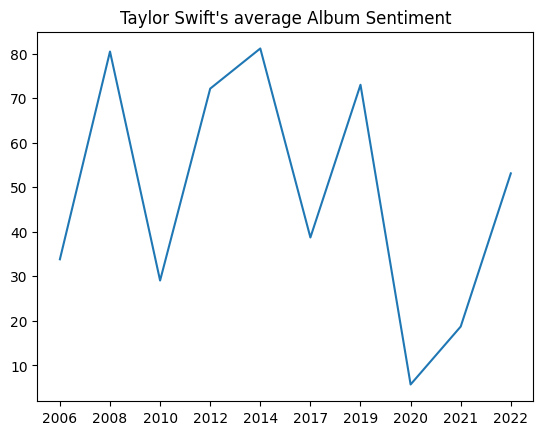

In [55]:
#create a new DataFrame using the groupby method for the album_year
yearly_sentiment = (
    lyrics.groupby('album_year')[lyrics.select_dtypes(include=['number', 'bool']).columns]
    .sum()
    .reset_index()
)
#visualize sentiment over time 
plt.plot(yearly_sentiment['album_year'], yearly_sentiment['compound'])
plt.title("Taylor Swift's average Album Sentiment")
plt.show()

#### 13. Day or Night? Positive or Negative

Finally the big reveal. Does Taylor Swift write more positively about day or night?

In [56]:
#create a DataFrame filtered for only night mentions
night = lyrics[lyrics['night']==True]

#create a DataFrame filtered for only day mentions
day = lyrics[lyrics['day']==True]

#print the length of the night and day DataFrames
print("night: ",len(night))
print("day: ",len(day))

night:  287
day:  387


In [57]:
#calculate the sentiment of each day and night DataFrame from the compound values
night_sentiment = night['compound'].sum()
day_sentiment = day['compound'].sum()

#print the results
print("night sentiment: ", night_sentiment)
print("day_sentiment: ", day_sentiment)

night sentiment:  19.7677
day_sentiment:  26.58


She's still overall more positive in her sentiment about day than night!
